In [1]:
# %load_ext autoreload
# %autoreload 2

%matplotlib inline

from IPython.display import display

from scipy.stats import pearsonr

import pandas as pd
import numpy as np
import src.exp.sklearn_models as exp_sk
import exp_pred_muni_crime as exp_pred
import json

In [2]:
from IPython.display import display_html
def display_side_by_side(dfs, headers=None):
    html_str=''
    for i, df in enumerate(dfs):
        df_sty = df.style.set_table_attributes("style='display:inline'")
        if headers is not None:
            df_sty = df_sty.set_caption(headers[i])
        html_str+=df_sty._repr_html_()
    display_html(html_str,raw=True)

In [3]:
from collections import defaultdict

# load data

In [4]:
data = pd.read_csv('data/SigSpatial_crime_data_full.csv')
data['income_group'] = pd.qcut(data['aver_income'], 4, labels=['q1','q2','q3','q4'])
pi = data['PI_type']
ic = data['income_group']
data_idx = data.index.tolist()
# idx_json = exp_pred.get_train_test_splits()
idx_json = exp_pred.get_5fold_split(random_state=0)

In [5]:
pi.value_counts().sort_index()

PI NONE            5
PI<40%,1~4999    955
PI<40%,>5000     213
PI>40%           206
Name: PI_type, dtype: int64

In [6]:
# seed_n = [1,3,4,5,6,7,8]
# seed_n = list(range(10))
# seed_n = list(range(20))
# seed_n = [15, 7, 10, 9, 6, 19, 16, 5, 1, 0, 3, 18, 8, 11, 12, 2, 17, 14, 4, 13][10:]
# seed_n = [0, 1,2,3,5,6,12,16,17,18]
seed_n = list(range(5))

In [7]:
pi_distr = []
ic_distr = []

for idx in idx_json:
    if int(idx['ith']) not in seed_n:
        continue
    train_pi = data.loc[idx['train']].PI_type.value_counts()
    train_pi.name = (idx['ith'], 'train')
    test_pi = data.loc[idx['test']].PI_type.value_counts()
    test_pi.name = (idx['ith'], 'test')
    pi_distr.extend([train_pi, test_pi])
    
    train_ic = data.loc[idx['train']].income_group.value_counts()
    train_ic.name = (idx['ith'], 'train')
    test_ic = data.loc[idx['test']].income_group.value_counts()
    test_ic.name = (idx['ith'], 'test')
    ic_distr.extend([train_ic, test_ic])
    


display(pd.concat(pi_distr, axis=1, sort=True))
display(pd.concat(ic_distr, axis=1, sort=True))

0            1          2          3          4       
              train   test train test train test train test train   test
PI NONE           5    NaN     3    2     4    1     3    2     5    NaN
PI<40%,1~4999   757  198.0   759  196   773  182   761  194   770  185.0
PI<40%,>5000    170   43.0   171   42   168   45   166   47   177   36.0
PI>40%          171   35.0   170   36   158   48   173   33   152   54.0

0          1          2          3          4     
   train test train test train test train test train test
q1   290   55   282   63   273   72   275   70   260   85
q2   270   75   278   67   278   67   274   71   280   65
q3   289   55   272   72   279   65   267   77   269   75
q4   254   91   271   74   273   72   287   58   295   50

In [49]:

z = data['vio_cnt']
ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_vio_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_vio_Pop_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_vio_noScale_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_vio_rs10-5fold.json'))

# z = data['pro_cnt']
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_Pop_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_Pop_noScale_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_noScale_5fold.json'))
# ml_pred_z = json.load(open('exp_result/SigSpatial/ml_pred_z_rate_5fold.json'))


for n in ['ols', 'ridge', 'lasso', 'DTreg', 'SVR', 'linearSVR', 'ADAreg']:
    ml_pred_z.pop(n)


In [50]:
# bmodel = 'BayPoisNoScale'
# bmodel = 'SigSpatialModel_pro_log_8a2b'
bmodel = 'SigSpatialModel_vio_log_8a6b'
ml_pred_z[bmodel] = defaultdict(dict)
for idx in idx_json:
    if int(idx['ith']) not in seed_n:
        continue
    i = int(idx['ith']) + 1
    folder = f'exp_result/SigSpatial/{bmodel}/5fold-{i}'
    ml_pred_z[bmodel][str(i-1)] = {
        'seed':
        idx['seed'],
        'train_pred':pd.read_csv(f'{folder}/pred_train_z.csv',index_col=0)['mean'].tolist(),
        'test_pred':pd.read_csv(f'{folder}/pred_test_z.csv', index_col=0)['mean'].tolist()
    }

In [51]:
ml_pred_y = {}
ml_pred_y[bmodel] = defaultdict(dict)
for idx in idx_json:
    if int(idx['ith']) not in seed_n:
        continue
    i = int(idx['ith']) + 1
    folder = f'exp_result/SigSpatial/{bmodel}/5fold-{i}'
    ml_pred_y[bmodel][str(i-1)] = {
        'seed':
        idx['seed'],
        'train':pd.read_csv(f'{folder}/pred_train_y.csv',index_col=0)['mean'].tolist(),
        'test':pd.read_csv(f'{folder}/pred_test_y.csv', index_col=0)['mean'].tolist()
    }

In [52]:
model_names = list(ml_pred_z.keys())
model_names

['GDBreg', 'RFreg', 'BAGreg', 'XGBreg', 'SigSpatialModel_vio_log_8a6b']

In [12]:
group_names = ['PI_type', 'income_group']

In [13]:
pi_gps = ['PI NONE', 'PI<40%,1~4999', 'PI<40%,>5000', 'PI>40%']

# compute fairness

Controlling Attribute Effect in Linear Regression: 
After remove the explanatory bias, to compensate for the remaining, unexplainable bias 
- the first constraint imposes that the mean prediction needs to be the same for the different batches or groups.
- The second constraint expresses that the mean residuals needs to be the same; that is, the errors for the different groups need to be balanced 

Regression fairness:
- FairST: Equitable Spatial and Temporal Demand Prediction for New Mobility Systems

In [14]:
from scipy.stats import pearsonr, spearmanr

In [15]:
def compute_error(df):
    true = df.true
    for mname in model_names:
        pred = df[mname]
        df[f'{mname}_SE'] = (true - pred)**2
        df[f'{mname}_E'] = pred - true
        df[f'{mname}_AE'] = df[f'{mname}_E'].abs()

In [16]:
def mean_err(df, mname, cor=True):
    rmse = pd.np.sqrt(df[mname+'_SE'].mean())
    mae = df[mname+'_AE'].mean()
    me = df[mname+'_E'].mean()
    me_neg = df[df[mname+'_E']<0][mname+'_E'].mean()
    me_pos = df[df[mname+'_E']>0][mname+'_E'].mean()
    err =  {'RMSE': round(rmse,2), 'MAE': round(mae,2), '+ME': round(me_pos,2), '-ME': round(me_neg,2),'ME':round(me,2),}
    
    if cor:
        true = df.true
        pred = df[mname]
        pea_cor, pea_p = pearsonr(true, pred)
        spe_cor, spe_p = spearmanr(true, pred)
        r2 = exp_sk.r2_score(true, pred)
        err.update({'pea_cor': pea_cor, 'pea_p': pea_p, 'spe_cor': spe_cor, 'spe_p':spe_p, 'r2': r2})
    return err


In [17]:
def compile_predictions(train_test_id, popu=False):
    idx = idx_json[train_test_id]
    if popu:
        train_z = z.loc[idx['train']]/data.loc[idx['train']]['popu']
        test_z = z.loc[idx['test']]/data.loc[idx['test']]['popu']
        
    else:
        train_z = z.loc[idx['train']]
        test_z = z.loc[idx['test']]
        
    train_eval = {'true': train_z}
    test_eval = {'true': test_z}

    for mname, predictions in ml_pred_z.items():
        pred = predictions[str(idx['ith'])]
        train_eval[mname] = pred['train_pred']
        test_eval[mname] = pred['test_pred']


    train_eval = pd.DataFrame(train_eval)
    test_eval = pd.DataFrame(test_eval)

    compute_error(train_eval)
    compute_error(test_eval)

    test_eval = test_eval.join(data[['PI_type','income_group']], how='left')
    train_eval = train_eval.join(data[['PI_type','income_group']], how='left')
    return train_eval, test_eval

In [53]:
# merr list: mean error for diff runs. 
# eval list: prediction, SE AE for each munic, used in 2.1 and 2.2 fair per group
train_merr_list, test_merr_list, train_eval_list, test_eval_list = [], [], [], []
for tr_te_i in seed_n:
    train_eval, test_eval = compile_predictions(tr_te_i, popu=False)
    train_eval_list.append(train_eval)
    test_eval_list.append(test_eval)
    
    test_merr = {mname: mean_err(test_eval, mname) for mname in model_names}
    test_merr = pd.DataFrame(test_merr)
    test_merr_list.append(test_merr)

    train_merr = {mname: mean_err(train_eval, mname) for mname in model_names}
    train_merr = pd.DataFrame(train_merr)
    train_merr_list.append(train_merr)

display_side_by_side([sum(test_merr_list)/len(seed_n), sum(train_merr_list)/len(seed_n)],['test', 'train'])

,GDBreg,RFreg,BAGreg,XGBreg,SigSpatialModel_vio_log_8a6b
RMSE,1271.35,1301.37,1294.48,1305.99,1160.02
MAE,408.912,404.704,406.112,404.926,346.104
+ME,316.75,273.196,275.704,320.508,291.06
-ME,-584.874,-808.338,-853.278,-536.71,-430.894
ME,-13.562,2.084,18.52,-18.75,5.606
pea_cor,0.739397,0.733981,0.737117,0.728152,0.813401
pea_p,2.44636e-33,2.76798e-31,7.35343e-32,1.99959e-33,2.52999e-45
spe_cor,0.607985,0.703148,0.681389,0.646448,0.666738
spe_p,1.5061e-15,9.18608e-35,9.64281e-34,1.88569e-25,2.11624e-26
r2,0.518384,0.505119,0.50377,0.496578,0.546647


In [54]:
pd.concat([te.loc['RMSE'] for te in test_merr_list], axis=1)

,RMSE,RMSE,RMSE,RMSE,RMSE
GDBreg,1649.75,1238.22,1402.73,660.50,1405.54
RFreg,1678.40,1227.68,1534.50,582.88,1483.41
BAGreg,1684.48,1176.58,1469.12,649.08,1493.12
XGBreg,1650.86,1277.69,1476.42,632.09,1492.88
SigSpatialModel_vio_log_8a6b,1201.12,1342.29,1171.73,891.07,1193.88


In [55]:
te_avg_merr = sum(test_merr_list)/len(seed_n)

In [56]:
te_avg_merr.columns=['GDB','RF','BAG','XGB','BURC']
print(te_avg_merr.loc[['RMSE','MAE','pea_cor'], ['RF','BAG','XGB','BURC']].applymap(lambda x: f'{x:.02f}').to_latex())

\begin{tabular}{lllll}
\toprule
{} &       RF &      BAG &      XGB &     BURC \\
\midrule
RMSE    &  1301.37 &  1294.48 &  1305.99 &  1160.02 \\
MAE     &   404.70 &   406.11 &   404.93 &   346.10 \\
pea\_cor &     0.73 &     0.74 &     0.73 &     0.81 \\
\bottomrule
\end{tabular}



In [57]:
eval_cols = [c for c in train_eval.columns if c not in group_names]

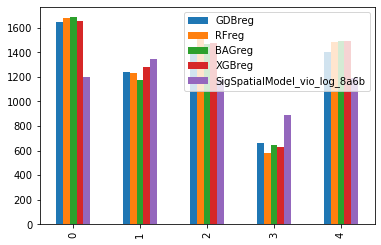

In [58]:
pd.concat({i: merr.loc['RMSE'] for i, merr in enumerate(test_merr_list)}, axis=1).T.plot(kind='bar')

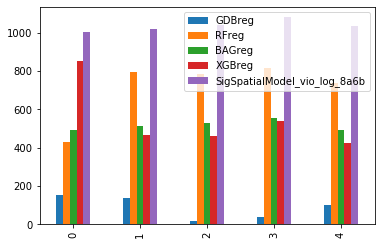

In [59]:
pd.concat({i: merr.loc['RMSE'] for i, merr in enumerate(train_merr_list)}, axis=1).T.plot(kind='bar')

In [60]:
def compile_infer(train_test_id):
    idx = idx_json[train_test_id]
    train_z = z.loc[idx['train']]
    test_z = z.loc[idx['test']]
    train_infer = {'true': train_z}
    test_infer = {'true': test_z}

    for mname, inference in ml_pred_y.items():
        infer = inference[str(idx['ith'])]
        train_infer[mname] = infer['train']
        test_infer[mname] = infer['test']


    train_infer = pd.DataFrame(train_infer)
    test_infer = pd.DataFrame(test_infer)

    test_infer = test_infer.join(data[['PI_type','income_group']], how='left')
    train_infer = train_infer.join(data[['PI_type','income_group']], how='left')
    return train_infer, test_infer

In [61]:
train_infer_list, test_infer_list = [], []
for tr_te_i in seed_n:
    train_infer, test_infer = compile_infer(tr_te_i)
    train_infer_list.append(train_infer)
    test_infer_list.append(test_infer)

## fair by expectation/group average

In [62]:
def fair_by_expectation(dat, mname, gname, vs='1 vs all', sqrt=True, norm_by_mean=False):
    # mname could be model name, comparing group prediction average
    # could also be model_err name, comparing group errors average
    fair = {}
    groups = sorted(dat[gname].unique())
    if vs=='1 vs all':
        for g in groups:
            # for RMSE comparison
            if '_SE' in mname and sqrt:
                fair[g] = np.sqrt(dat[dat[gname]==g][mname].mean()) - np.sqrt(dat[dat[gname]!=g][mname].mean())
            else:
                fair[g] = dat[dat[gname]==g][mname].mean() - dat[dat[gname]!=g][mname].mean()
            if norm_by_mean and not mname.endswith('E'):
                fair[g] /=dat[mname].mean()
        fair = pd.Series(fair)
    if vs == 'all vs all':
        for gi in groups:
            fair['i'+gi] = {}
            for gj in groups:
                # for RMSE comparison
                if '_SE' in mname and sqrt:
                    fair['i'+gi]['j'+gj] = np.sqrt(dat[dat[gname]==gi][mname].mean()) - np.sqrt(dat[dat[gname]==gj][mname].mean())
                else:
                    fair['i'+gi]['j'+gj] = dat[dat[gname]==gi][mname].mean() - dat[dat[gname]==gj][mname].mean()
                if norm_by_mean and not mname.endswith('E'):
                    fair['i'+gi]['j'+gj] /=dat[mname].mean()
        fair = pd.DataFrame(fair)
    return fair

In [63]:
def get_fair_exp_1vsall(train_test_id, norm_by_mean=False):
    test_eval = test_eval_list[train_test_id]
    train_eval = train_eval_list[train_test_id]

    vs = '1 vs all'
    fair_exp_1vsall = defaultdict(lambda: defaultdict(list))
    for gname in group_names:
        for dname, dat in [('train', train_eval), ('test',test_eval)]:
            for ecol in eval_cols:
                f = fair_by_expectation(dat, ecol, gname, vs=vs, norm_by_mean=norm_by_mean)
                f.name=ecol
                fair_exp_1vsall[gname][dname].append(f)
    return fair_exp_1vsall

### expectation of prediction

In [330]:
# reference
test_merr_list[4]

,RFreg,XGBreg,BAGreg,BayPois
RMSE,865.02,852.89,881.71,388.99
MAE,179.21,171.32,191.48,133.51
+ME,107.67,93.93,119.93,101.30
-ME,-364.11,-305.40,-443.66,-167.14


In [331]:
fair_exp_1vsall = get_fair_exp_1vsall(4, norm_by_mean=True)
pd.DataFrame(fair_exp_1vsall['income_group']['test']).head(len(model_names)+1)

,q1,q2,q3,q4
true,-1.300029,-1.156649,-0.699830,3.543722
RFreg,-1.186681,-0.882930,-0.687036,3.105432
XGBreg,-1.244691,-0.993801,-0.708728,3.316225
BAGreg,-1.200503,-0.951271,-0.625644,3.121637
BayPois,-1.286009,-1.166263,-0.655933,3.486054


In [332]:
pd.DataFrame(fair_exp_1vsall['PI_type']['test']).head(len(model_names)+1)

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%
true,-0.995964,-2.272021,4.185202,-1.000313
RFreg,-0.943714,-1.406511,2.809150,-0.885315
XGBreg,-0.900452,-1.424618,2.871523,-0.931673
BAGreg,-0.947264,-1.141349,2.482667,-0.969908
BayPois,-0.895340,-1.730212,3.418708,-1.050709


#### 1 vs all

In [64]:

fair_exp_1vsall_list = [get_fair_exp_1vsall(i,norm_by_mean=True) for i in range(len(seed_n))]

In [65]:
rename_index = {'true': 'RepCr', 'RFreg': 'RF','BAGreg': 'BAG', 'XGBreg': 'XGB', bmodel:'BURC', 'infer':'TrueCr'}

In [66]:
rename_columns = {'q1':'IcQ1','q2':'IcQ2', 'q3':'IcQ3', 'q4':'IcQ4', 'PI NONE': 'PI1',
                  'PI<40%,1~4999':'PI2', 'PI<40%,>5000': 'PI3', 'PI>40%': 'PI4'}

In [67]:
tmpdf = sum([pd.DataFrame(f['income_group']['test']).head(len(model_names)+1) for f in fair_exp_1vsall_list])
tmpdf.loc['infer']=sum([fair_by_expectation(test_infer_list[tr_te_i], bmodel,'income_group', norm_by_mean=True) for tr_te_i in range(len(seed_n))])
tmpdf/=len(seed_n)
# tmpdf['Sum'] = tmpdf.sum(axis=1)
tmpdf['AbsSum']=tmpdf.abs().sum(axis=1)
tmpdf

,q1,q2,q3,q4,AbsSum
true,-1.277662,-1.086387,-0.759150,3.196682,6.319881
GDBreg,-1.183148,-0.961114,-0.600078,2.796066,5.540407
RFreg,-1.155683,-0.955467,-0.543264,2.701344,5.355758
BAGreg,-1.112652,-0.942252,-0.535151,2.652088,5.242144
XGBreg,-1.163022,-0.986989,-0.549802,2.760521,5.460333
SigSpatialModel_vio_log_8a6b,-1.215660,-1.010543,-0.688698,2.982402,5.897303
infer,-0.771686,-0.510128,-0.188346,1.471384,2.941544


In [68]:
print(tmpdf.drop('GDBreg').rename(
    columns={'q1':'IcQ1','q2':'IcQ2', 'q3':'IcQ3', 'q4':'IcQ4'},index=rename_index
).applymap(lambda x: f'{x:.2f}').to_latex())

\begin{tabular}{llllll}
\toprule
{} &   IcQ1 &   IcQ2 &   IcQ3 &  IcQ4 & AbsSum \\
\midrule
RepCr  &  -1.28 &  -1.09 &  -0.76 &  3.20 &   6.32 \\
RF     &  -1.16 &  -0.96 &  -0.54 &  2.70 &   5.36 \\
BAG    &  -1.11 &  -0.94 &  -0.54 &  2.65 &   5.24 \\
XGB    &  -1.16 &  -0.99 &  -0.55 &  2.76 &   5.46 \\
BURC   &  -1.22 &  -1.01 &  -0.69 &  2.98 &   5.90 \\
TrueCr &  -0.77 &  -0.51 &  -0.19 &  1.47 &   2.94 \\
\bottomrule
\end{tabular}



In [69]:
tmpdf = sum([pd.DataFrame(f['PI_type']['test'], columns=pi_gps).head(len(model_names)+1).fillna(0) for f in fair_exp_1vsall_list])
tmpdf.loc['infer'] = sum([fair_by_expectation(test_infer_list[tr_te_i], bmodel,'PI_type', norm_by_mean=True).reindex(pi_gps,fill_value=0) for tr_te_i in range(len(seed_n))])
tmpdf/=len(seed_n)
# tmpdf['Sum'] = tmpdf.sum(axis=1)
tmpdf['AbsSum']=tmpdf.abs().sum(axis=1)
tmpdf.drop('GDBreg').rename(columns={'q1':'income-q1','q2':'income-q2', 'q3':'income-q3', 'q4':'income-q4'},
                           index=rename_index)

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%,AbsSum
RepCr,-0.598340,-1.946289,4.221420,-1.023436,7.789484
RF,-0.453914,-1.119770,2.726306,-0.900820,5.200810
BAG,-0.432306,-1.125937,2.686063,-0.853732,5.098038
XGB,-0.486884,-1.265373,2.957184,-0.890154,5.599594
BURC,-0.572709,-1.605088,3.621561,-1.015865,6.815223
TrueCr,-0.459734,-0.854357,1.840574,-0.473496,3.628161


In [70]:
print(tmpdf.drop('GDBreg').rename(
    columns=rename_columns,index=rename_index
).applymap(lambda x: f'{x:.2f}').to_latex())

\begin{tabular}{llllll}
\toprule
{} &    PI1 &    PI2 &   PI3 &    PI4 & AbsSum \\
\midrule
RepCr  &  -0.60 &  -1.95 &  4.22 &  -1.02 &   7.79 \\
RF     &  -0.45 &  -1.12 &  2.73 &  -0.90 &   5.20 \\
BAG    &  -0.43 &  -1.13 &  2.69 &  -0.85 &   5.10 \\
XGB    &  -0.49 &  -1.27 &  2.96 &  -0.89 &   5.60 \\
BURC   &  -0.57 &  -1.61 &  3.62 &  -1.02 &   6.82 \\
TrueCr &  -0.46 &  -0.85 &  1.84 &  -0.47 &   3.63 \\
\bottomrule
\end{tabular}



#### all vs all

In [30]:
fair_exp_ava_income_aver = {
    **{
        col:[
            fair_by_expectation(test_eval_list[tr_te_i], col,'income_group', norm_by_mean=True, vs='all vs all').abs().sum().sum()/2
            for tr_te_i in range(len(seed_n))
        ] for col in ['true']+model_names},
    'Infer':[
            fair_by_expectation(test_infer_list[tr_te_i], 'BayPoisNoScale','income_group', norm_by_mean=True, vs='all vs all').abs().sum().sum()/2
            for tr_te_i in range(len(seed_n))
        ] 
}
pd.DataFrame(fair_exp_ava_income_aver).mean()

true              10.944885
GDBreg             9.724462
RFreg              9.402979
BAGreg             9.185788
XGBreg             9.747132
BayPoisNoScale    10.505151
Infer              6.413557
dtype: float64

In [31]:
fair_exp_ava_pi_aver = {
    **{
        col:[
            fair_by_expectation(test_eval_list[tr_te_i], col,'PI_type', norm_by_mean=True, vs='all vs all').abs().sum().sum()/2
            for tr_te_i in range(len(seed_n))
        ] for col in ['true']+model_names},
    'Infer':[
            fair_by_expectation(test_infer_list[tr_te_i], 'BayPoisNoScale','PI_type', norm_by_mean=True, vs='all vs all').abs().sum().sum()/2
            for tr_te_i in range(len(seed_n))
        ] 
}
pd.DataFrame(fair_exp_ava_pi_aver).mean()

true              12.350775
GDBreg             9.131834
RFreg              8.740024
BAGreg             8.038509
XGBreg             8.837546
BayPoisNoScale     9.854224
Infer              7.264071
dtype: float64

### expecation of error

In [355]:
pd.DataFrame(fair_exp_1vsall['PI_type']['test']).loc[[m+'_AE' for m in model_names]]

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%
RFreg_AE,-167.629846,-305.853577,579.380732,-153.832374
XGBreg_AE,-152.335251,-303.573490,578.279222,-157.208333
BAGreg_AE,-179.695561,-263.820578,542.335718,-185.506798
BayPois_AE,-110.913438,-194.212932,384.386820,-118.423751


In [474]:
etype='_E'
tmpdf=pd.concat([pd.DataFrame(f['PI_type']['test']).fillna(0).loc[[m+etype for m in model_names]] for f in fair_exp_1vsall_list],sort=False).groupby(level=0).mean()
tmpdf['Sum'] = tmpdf.sum(axis=1)
tmpdf['AbsSum']=tmpdf.abs().sum(axis=1)
tmpdf

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%,Sum,AbsSum
BAGreg_E,-2.225321,221.992433,-379.883696,20.287602,-139.828982,764.218034
BayPois_E,31.015990,172.119154,-286.373742,6.373440,-76.865158,572.747483
RFreg_E,-3.359632,180.231077,-303.472402,15.897375,-110.703582,613.664068
XGBreg_E,34.552136,200.445648,-329.907666,9.936442,-84.973441,659.815333


In [357]:
pd.DataFrame(fair_exp_1vsall['income_group']['test']).loc[[m+'_AE' for m in model_names]]

,q1,q2,q3,q4
RFreg_AE,-210.342187,-160.391012,-93.465199,520.907593
XGBreg_AE,-209.890213,-180.179136,-90.372406,538.095057
BAGreg_AE,-228.465173,-187.240175,-120.420304,602.392434
BayPois_AE,-162.115310,-133.232269,-24.199057,354.858799


In [475]:
etype='_AE'
tmpdf=pd.concat([pd.DataFrame(f['income_group']['test']).fillna(0).loc[[m+etype for m in model_names]] for f in fair_exp_1vsall_list],sort=False).groupby(level=0).mean()
tmpdf['Sum'] = tmpdf.sum(axis=1)
tmpdf['AbsSum']=tmpdf.abs().sum(axis=1)
tmpdf

,q1,q2,q3,q4,Sum,AbsSum
BAGreg_AE,-230.245788,-182.395262,-118.596262,549.702001,18.464690,1099.404003
BayPois_AE,-196.275293,-163.272275,-84.019860,458.926220,15.358792,917.852440
RFreg_AE,-227.908066,-183.761209,-115.761727,545.009783,17.578782,1090.019566
XGBreg_AE,-218.474926,-188.331675,-116.916548,542.559974,18.836824,1085.119948


In [359]:
pd.DataFrame(fair_exp_1vsall['income_group']['test']).loc[[m+'_SE' for m in model_names]]

,q1,q2,q3,q4
RFreg_SE,-938.240425,-822.200037,-770.707007,1649.758618
XGBreg_SE,-959.883323,-885.203801,-771.613493,1662.048112
BAGreg_SE,-983.267808,-918.101289,-845.554628,1748.810105
BayPois_SE,-424.317094,-391.424496,-212.759589,652.410948


In [476]:
etype='_E'
tmpdf=pd.concat([pd.DataFrame(f['income_group']['test']).fillna(0).loc[[m+etype for m in model_names]] for f in fair_exp_1vsall_list],sort=False).groupby(level=0).mean()
tmpdf['Sum'] = tmpdf.sum(axis=1)
tmpdf['AbsSum']=tmpdf.abs().sum(axis=1)
tmpdf

,q1,q2,q3,q4,Sum,AbsSum
BAGreg_E,5.759584,37.280169,56.505003,-96.680118,2.864637,199.089511
BayPois_E,16.440232,16.802785,50.866781,-81.300129,2.809669,168.219597
RFreg_E,8.207182,31.627482,33.708319,-69.055999,4.486984,147.085966
XGBreg_E,21.513950,28.708411,24.897630,-71.610367,3.509624,150.239982


## fair by in-group error

In [71]:
def reorg_in_group_err(gname, err_type, fair_err, display=True):
    
    df_test = pd.DataFrame({mname:fair_err[gname]['test'][mname].loc[err_type] for mname in model_names})
    df_train= pd.DataFrame({mname:fair_err[gname]['train'][mname].loc[err_type] for mname in model_names})
    if display:
        print(gname, err_type)
        display_side_by_side(dfs=[df_test, df_train], headers=['test', 'train'])
    else:
        if gname=='PI_type':
            df_test = df_test.reindex(pi_gps)
            df_train = df_train.reindex(pi_gps)
        return df_test, df_train

In [72]:
def fair_in_group_error(train_test_id, gname, err_type,norm_by_gmean=False):
    train_eval = train_eval_list[train_test_id]
    test_eval = test_eval_list[train_test_id]
    fair_in_group_err = defaultdict(lambda: defaultdict(dict))
    for dname, dat in [('train', train_eval), ('test',test_eval)]:
        for mname in model_names:
            ig_err = pd.DataFrame(dat.groupby(gname).apply(lambda df: mean_err(df, mname, cor=False)).to_dict())
            if norm_by_gmean:
                ig_err /= dat.groupby(gname)['true'].mean().replace(0,1)
            fair_in_group_err[gname][dname][mname] = ig_err
    te, tr = reorg_in_group_err(gname, err_type, fair_in_group_err,display=False)
    return te, tr

In [73]:
def mean_list_df_ignore_nan(df_list):
    values = np.nanmean([f.values for f in fair_in_g_err_test_list],axis=0)
    return pd.DataFrame(values, index=df_list[0].index, columns=df_list[0].columns)

In [79]:
gname, err_type, norm_by_gmean = 'PI_type', 'RMSE', False
fair_in_g_err_test_list, fair_in_g_err_train_list = [],[]
for tr_te_id in range(len(seed_n)):
    test_err, train_err = fair_in_group_error(tr_te_id, gname, err_type, norm_by_gmean=norm_by_gmean)
    fair_in_g_err_test_list.append(test_err)
    fair_in_g_err_train_list.append(train_err)
tmpdf1 = mean_list_df_ignore_nan(fair_in_g_err_test_list)

gname, err_type, norm_by_gmean = 'PI_type', 'RMSE', True
fair_in_g_err_test_list, fair_in_g_err_train_list = [],[]
for tr_te_id in range(len(seed_n)):
    test_err, train_err = fair_in_group_error(tr_te_id, gname, err_type, norm_by_gmean=norm_by_gmean)
    fair_in_g_err_test_list.append(test_err)
    fair_in_g_err_train_list.append(train_err)
tmpdf2 = mean_list_df_ignore_nan(fair_in_g_err_test_list)
tmpdf1

,GDBreg,RFreg,BAGreg,XGBreg,SigSpatialModel_vio_log_8a6b
PI NONE,125.460,109.480,127.510,211.826667,22.910
"PI<40%,1~4999",538.120,502.502,522.054,518.188000,518.398
"PI<40%,>5000",3001.018,3128.016,3078.018,3131.642000,2719.838
PI>40%,213.724,189.678,302.912,255.310000,120.174


In [80]:
latex_df = (
    tmpdf1.T.drop('GDBreg').rename(columns=rename_columns, index=rename_index).applymap(lambda x: f'{x:.1f}') +
    tmpdf2.T.drop('GDBreg').rename(columns=rename_columns, index=rename_index).applymap(lambda x: f' ({x:.1f})')
    
)
print(latex_df.to_latex())

\begin{tabular}{lllll}
\toprule
{} &           PI1 &          PI2 &           PI3 &          PI4 \\
\midrule
RF   &  109.5 (33.9) &  502.5 (2.5) &  3128.0 (1.3) &  189.7 (3.0) \\
BAG  &  127.5 (31.9) &  522.1 (2.6) &  3078.0 (1.3) &  302.9 (4.7) \\
XGB  &  211.8 (93.6) &  518.2 (2.6) &  3131.6 (1.3) &  255.3 (4.0) \\
BURC &    22.9 (9.8) &  518.4 (2.7) &  2719.8 (1.2) &  120.2 (1.8) \\
\bottomrule
\end{tabular}



In [81]:
gname, err_type, norm_by_gmean = 'income_group', 'RMSE', False
fair_in_g_err_test_list, fair_in_g_err_train_list = [],[]
for tr_te_id in range(len(seed_n)):
    test_err, train_err = fair_in_group_error(tr_te_id, gname, err_type, norm_by_gmean=norm_by_gmean )
    fair_in_g_err_test_list.append(test_err)
    fair_in_g_err_train_list.append(train_err)

tmpdf1 = mean_list_df_ignore_nan(fair_in_g_err_test_list)

gname, err_type, norm_by_gmean = 'income_group', 'RMSE', True
fair_in_g_err_test_list, fair_in_g_err_train_list = [],[]
for tr_te_id in range(len(seed_n)):
    test_err, train_err = fair_in_group_error(tr_te_id, gname, err_type, norm_by_gmean=norm_by_gmean )
    fair_in_g_err_test_list.append(test_err)
    fair_in_g_err_train_list.append(train_err)

tmpdf2 = mean_list_df_ignore_nan(fair_in_g_err_test_list)
tmpdf1

,GDBreg,RFreg,BAGreg,XGBreg,SigSpatialModel_vio_log_8a6b
q1,143.006,101.962,205.766,168.576,98.158
q2,261.602,183.846,195.010,226.178,194.744
q3,396.682,390.020,393.034,378.636,331.930
q4,2485.344,2560.392,2547.736,2568.930,2305.410


In [82]:
latex_df = (
    tmpdf1.T.drop('GDBreg').rename(columns=rename_columns, index=rename_index).applymap(lambda x: f'{x:.1f}') +
    tmpdf2.T.drop('GDBreg').rename(columns=rename_columns, index=rename_index).applymap(lambda x: f' ({x:.1f})')
    
)
print(latex_df.to_latex())

\begin{tabular}{lllll}
\toprule
{} &         IcQ1 &         IcQ2 &         IcQ3 &          IcQ4 \\
\midrule
RF   &  102.0 (4.7) &  183.8 (2.3) &  390.0 (2.0) &  2560.4 (1.4) \\
BAG  &  205.8 (9.6) &  195.0 (2.5) &  393.0 (2.1) &  2547.7 (1.4) \\
XGB  &  168.6 (8.0) &  226.2 (2.9) &  378.6 (2.0) &  2568.9 (1.4) \\
BURC &   98.2 (4.7) &  194.7 (2.4) &  331.9 (1.7) &  2305.4 (1.4) \\
\bottomrule
\end{tabular}



In [36]:
sum(test_merr_list)/len(seed_n)

,GDBreg,RFreg,BAGreg,XGBreg,BayPoisNoScale
RMSE,822.404,763.068,803.822,810.752,601.192
MAE,217.576,198.378,210.540,211.492,180.398
+ME,174.004,130.508,136.292,154.214,160.116
-ME,-293.480,-365.122,-456.926,-316.510,-208.060
ME,1.720,-14.814,-1.274,-9.766,3.452


In [59]:
train_eval = train_eval_list[4]
test_eval = test_eval_list[4]
test_merr_list[4]

,GDBreg,RFreg,BAGreg,BayPoisNoScale
RMSE,1066.60,1063.72,1045.03,769.96
MAE,237.71,189.03,195.38,303.39
+ME,236.91,150.97,141.47,281.24
-ME,-238.58,-273.10,-385.36,-446.47
ME,9.50,18.83,25.03,183.69


In [410]:
fair_in_group_err = defaultdict(lambda: defaultdict(dict))
for gname in group_names:
    for dname, dat in [('train', train_eval), ('test',test_eval)]:
        for mname in model_names:
            fair_in_group_err[gname][dname][mname] = pd.DataFrame(
                dat.groupby(gname).apply(lambda df: mean_err(df, mname)).to_dict())

In [364]:
display_side_by_side([test_merr, train_merr],['test', 'train'])

,RFreg,XGBreg,BAGreg,BayPois
RMSE,453.14,449.8,420.09,385.41
MAE,168.23,158.87,165.79,145.61
+ME,163.75,166.9,149.22,151.21
-ME,-186.21,-142.02,-246.53,-137.28
,RFreg,XGBreg,BAGreg,BayPois
RMSE,547.02,625.75,352.72,618.25
MAE,119.97,137.24,89.98,179.6
+ME,81.69,97.33,59.58,158.49
-ME,-225.82,-202.38,-185.16,-207.19


In [365]:
gname, err_type = 'PI_type', 'RMSE'
reorg_in_group_err(gname, err_type, fair_in_group_err)

PI_type RMSE


,RFreg,XGBreg,BAGreg,BayPois
PI NONE,12.19,19.53,12.44,22.99
"PI<40%,1~4999",194.21,196.02,279.01,186.57
"PI<40%,>5000",2035.25,2006.33,2039.04,853.85
PI>40%,116.7,76.71,59.82,57.45
,RFreg,XGBreg,BAGreg,BayPois
PI NONE,7.24,67.1,13.99,64.97
"PI<40%,1~4999",188.47,204.54,127.03,397.75
"PI<40%,>5000",1286.35,1434.81,797.65,1384.54
PI>40%,35.12,56.74,27.7,50


In [366]:
gname, err_type = 'income_group', 'RMSE'
reorg_in_group_err(gname, err_type, fair_in_group_err)

income_group RMSE


,RFreg,XGBreg,BAGreg,BayPois
q1,64.74,29.59,39.53,26.76
q2,167.33,93.48,93.74,54.52
q3,239.47,225.37,188.68,224.38
q4,1825.17,1808.13,1875.68,791.47
,RFreg,XGBreg,BAGreg,BayPois
q1,13.32,36.42,15.28,20.21
q2,45.84,50.28,36.42,61.74
q3,150.98,127.23,104.83,150.14
q4,1015.11,1134.53,632.69,1228.95


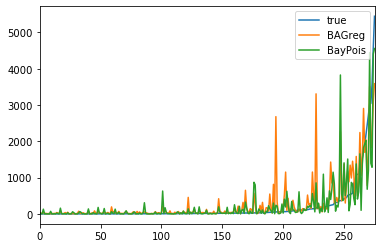

In [109]:
test_eval.sort_values('true')[['true', 'BAGreg','BayPois']].reset_index(drop=True).plot()

In [75]:
gname, err_type = 'income_group', 'MAE'
reorg_in_group_err(gname, err_type, fair_in_group_err)

income_group MAE


,RFreg,XGBreg,BAGreg,BayPois
q1,15.25,15.98,18.78,11.32
q2,40.77,35.66,47.55,28.82
q3,100.36,90.39,105.54,64.02
q4,646.83,695.09,647.71,522.91
,RFreg,XGBreg,BAGreg,BayPois
q1,21.08,14.42,12.66,13.41
q2,36.87,28.03,19.58,34.68
q3,68.68,58.66,48.83,100.99
q4,368.94,417.73,247.54,547.28
